# Analytische Vaardigheden




Importeren van de dependencies


In [122]:
import numpy as np
import pandas as pd
import scipy.stats as stats
import datetime
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
pd.options.mode.chained_assignment = None

## Het inladen van de dataset
Eerst laden we de dataset in

In [123]:
indexes = pd.read_csv('GSPC.csv')
indexes.head()


,Date,Open,High,Low,Close,Adj Close,Volume
0,1950-01-03,16.66,16.66,16.66,16.66,16.66,1260000
1,1950-01-04,16.85,16.85,16.85,16.85,16.85,1890000
2,1950-01-05,16.93,16.93,16.93,16.93,16.93,2550000
3,1950-01-06,16.98,16.98,16.98,16.98,16.98,2010000
4,1950-01-09,17.08,17.08,17.08,17.08,17.08,2520000


## Historisch rendement berekenen

In [124]:
# Pak de start prijs van de dataset en eindprijs
startPrice = float(indexes['Open'][0])
endPrice = float(indexes['Open'][len(indexes['Open'])-1])

# Pak het start jaar en het eindjaar
startDate = int(indexes['Date'][0][:4])
endDate = int(indexes['Date'][len(indexes['Date'])-1][:4])

# Bereken het jaarlijks rendement
historischRendement = (endPrice/startPrice)**(1/(endDate-startDate))-1

## Het schoonmaken
Dan gaan we de dataset schoonmaken en alle kolommen droppen die we niet meer gaan gebruiken. Ook maken we van de kolomnamen kleine letters want dat is handig!

In [125]:
indexes['date'] = pd.to_datetime(indexes['Date'])
indexes['open'] = indexes['Open']
columns_to_keep = [
    'date',
    'open'
]
indexes = indexes[columns_to_keep]
indexes.head()

,date,open
0,1950-01-03,16.66
1,1950-01-04,16.85
2,1950-01-05,16.93
3,1950-01-06,16.98
4,1950-01-09,17.08


Nu gaan we de startjaar en eindjaar bepalen

In [126]:
startjaar = 2016
duur = 6
eindjaar = startjaar + duur
eindjaar

2022

Stel de rente in op de lening en het jaarlijks rendement op de staatslening beleggingen

In [127]:
leningrente = 0.0234
bondsrendement = 0.0171

Nu gaan we een nieuwe Dataframe maken waar al onze resultaten in komen, we maken er eerst eentje met alle datums waar we gaan investeren. 

In [128]:
jaren = pd.date_range(str(startjaar) + "-09-01", periods=duur + 1, freq='AS-SEP')
df = pd.DataFrame({'date': jaren, 'schuld met rente 0.00': 0.0, 'schuld met rente {}'.format(leningrente*100): 0.0})
df.head()

,date,schuld met rente 0.00,schuld met rente 2.34
0,2016-09-01,0.0,0.0
1,2017-09-01,0.0,0.0
2,2018-09-01,0.0,0.0
3,2019-09-01,0.0,0.0
4,2020-09-01,0.0,0.0


Nu gaan we de maandelijkse studiefinanciering bepalen, deze is te vinden op de site van DUO.

In [129]:
lening = 486.08
beurs = 396.39
collegegeldkrediet = 173.59
totaal = lening + beurs + collegegeldkrediet
totaal

1056.06

Dat is wat we per maand kunnen krijgen van Ome duo. Per jaar is dat dus:

In [130]:
totaal = totaal * 12
totaal

12672.72

Op 1 september van het eerste jaar hebben we nog geen geld, want dan beginnen we pas, dus dan is de schuld 0

In [131]:
df['schuld met rente 0.00'][0] = 0
df['schuld met rente {}'.format(leningrente*100)][0] = 0
df

,date,schuld met rente 0.00,schuld met rente 2.34
0,2016-09-01,0.0,0.0
1,2017-09-01,0.0,0.0
2,2018-09-01,0.0,0.0
3,2019-09-01,0.0,0.0
4,2020-09-01,0.0,0.0
5,2021-09-01,0.0,0.0
6,2022-09-01,0.0,0.0


Doordat er in de dataset niet altijd een 1 september te vinden is, omdat er in het weekend de markten niet open zijn, gaan we kijken wat de eerstvolgende datum is dat er wel een waarde beschikbaar is

In [132]:
def get_day_value(date):
    global df, indexes
    if len(indexes[indexes['date'] != date]) != len(indexes) - 1:
        return get_day_value(date + datetime.timedelta(days=1))
    # Check of datum in de toekomst van de dataset ligt
    else:
        return indexes[indexes['date'] == date]

# Variable to save previous price
firstFuturePrice = True

for index, row in df.iterrows():
    if int(str(df['date'][index])[:4]) <= (endDate-1):
        df['date'][index] = get_day_value(row['date']).iloc[0]['date']
    else:
        # Verkrijg data
        date = df['date'][index]
        
        # Eerste run, pak de open prijs op basis van de vorige date
        if firstFuturePrice == True:
            openPrice = (float(indexes['open'][len(indexes)-1]))
            firstFuturePrice = False
        # Neem de vorige prijs uit de dataset
        else:
            openPrice = (float(indexes['open'][len(indexes)-1])*(historischRendement+1))
        
        # Maak in de dataset de datum aan, deze bestaat alleen in de toekomst namelijk
        # Update de dataset
        indexes = indexes.append({'date': date, 'open': openPrice}, ignore_index=True)
        
df.head()
df = pd.merge(df, indexes, on='date')
df.head()

,date,schuld met rente 0.00,schuld met rente 2.34,open
0,2016-09-01,0.0,0.0,2171.330078
1,2017-09-01,0.0,0.0,2474.419922
2,2018-09-01,0.0,0.0,2753.250000
3,2019-09-01,0.0,0.0,2968.013039
4,2020-09-01,0.0,0.0,3199.528339


We voegen nog de kolommen toe voor de aantal aandelen en voor de rest van het geld

In [133]:
df['aandelen'] = 0
df['rest'] = 0
df.head()

,date,schuld met rente 0.00,schuld met rente 2.34,open,aandelen,rest
0,2016-09-01,0.0,0.0,2171.330078,0,0
1,2017-09-01,0.0,0.0,2474.419922,0,0
2,2018-09-01,0.0,0.0,2753.250000,0,0
3,2019-09-01,0.0,0.0,2968.013039,0,0
4,2020-09-01,0.0,0.0,3199.528339,0,0


Nu komt het gedeelte waar we elk jaar berekenen 

In [134]:
for index, row in df.iterrows():
    if index == 0:
        # Jaar 1 totaal = schuld
        df.loc[index, 'schuld met rente 0.00'] = totaal
        df.loc[index, 'schuld met rente {}'.format(leningrente*100)] = totaal
        df.loc[index, 'aandelen'] = 0 
        df.loc[index, 'rest'] = 0 
        
        # Waarde staatsleningen jaar 1 = totaal, er is nog niks belegd
        df.loc[index, 'waarde staatsleningen'] = totaal
        
    # Jaren waarin belegd wordt
    elif index <= 4:
        # Neem rente mee in de schuld = totaal * (1 + rente)^aantal jaren
        df.loc[index, 'schuld met rente 0.00'] = df.iloc[index - 1]['schuld met rente 0.00'] + totaal
        df.loc[index, 'schuld met rente {}'.format(leningrente*100)] = round(df.iloc[index - 1]['schuld met rente {}'.format(leningrente*100)] + (totaal * (1 + leningrente)**index),2)
        df.loc[index, 'aandelen'] = df.loc[index - 1, 'aandelen'] + np.floor((totaal + df.loc[index - 1, 'rest']) / row['open'])
        df.loc[index, 'rest'] = (totaal + df.loc[index -1, 'rest']) - np.floor((totaal + df.loc[index - 1, 'rest']) / row['open']) * row['open']
        df.loc[index, 'waarde staatsleningen'] = round(df.loc[index -1, 'waarde staatsleningen'] + (totaal * (1 + bondsrendement)**index),2)
    
    # Rente jaren
    else:
        # Neem rente mee in eindstand, voeg rente toe op de vorige schuld
        df.loc[index, 'schuld met rente 0.00'] = round(df.loc[index - 1, 'schuld met rente 0.00'])
        df.loc[index, 'schuld met rente {}'.format(leningrente*100)] = round(df.loc[index - 1, 'schuld met rente {}'.format(leningrente*100)] * (1 + leningrente ), 2)
        df.loc[index, 'aandelen'] = df.loc[index - 1, 'aandelen']
        df.loc[index, 'rest'] = df.loc[index - 1, 'rest']
        
        # Neem de laatste waarde en voeg daar nog eenmaal de rente op toe
        df.loc[index, 'waarde staatsleningen'] = round(df.loc[index - 1, 'waarde staatsleningen'] * (1 + bondsrendement),2)
        
df

,date,schuld met rente 0.00,schuld met rente 2.34,open,aandelen,rest,waarde staatsleningen
0,2016-09-01,12672.72,12672.72,2171.330078,0.0,0.000000,12672.72
1,2017-09-01,25345.44,25641.98,2474.419922,5.0,300.620390,25562.14
2,2018-09-01,38018.16,38914.72,2753.250000,9.0,1960.340390,38671.97
3,2019-09-01,50690.88,52498.04,2968.013039,13.0,2761.008234,52005.98
4,2020-09-01,63363.60,66399.21,3199.528339,17.0,2635.614879,65568.00
5,2021-09-01,63364.00,67952.95,3449.102634,17.0,2635.614879,66689.21
6,2022-09-01,63364.00,69543.05,3718.144590,17.0,2635.614879,67829.60


## Totaal rendement bij SP500 met en zonder rente

In [135]:
# Eind waarde van het SP500 portfolio berekenen
eindWaardeSP500 = round(df.loc[len(df) - 1, 'aandelen'] * df.loc[len(df) - 1, 'open'] + df.loc[len(df) - 1, 'rest'], 2)

# Aantal aandelen * open waarde uitstap jaar 
sp500zonderrente = round(df.loc[len(df) - 1, 'aandelen'] * df.loc[len(df) - 1, 'open'] + df.loc[len(df) - 1, 'rest'] - df.loc[len(df) -1, 'schuld met rente 0.00'], 2)
sp500metrente = round(df.loc[len(df) - 1, 'aandelen'] * df.loc[len(df) - 1, 'open'] + df.loc[len(df) - 1, 'rest'] - df.loc[len(df) -1, 'schuld met rente {}'.format(leningrente*100)], 2)

# Waarde staatsleningen - schuld met rente x.xx
staatsleningenzonderrente = round( df.loc[len(df) -1, 'waarde staatsleningen'] - df.loc[len(df) -1, 'schuld met rente 0.00'], 2)
staatsleningenmetrente = round(df.loc[len(df) -1, 'waarde staatsleningen'] - df.loc[len(df) -1, 'schuld met rente {}'.format(leningrente*100)], 2)

# Totale schuld
totaalSchuldZonderRente = float(df.loc[len(df) -1, 'schuld met rente 0.00'])
totaalSchuldMetRente = float(df.loc[len(df) -1, 'schuld met rente {}'.format(leningrente*100)])

# Print de eindstand
print('Rendement in scenario {} tot en met {} met een jaarlijkse inleg van {:.2f} euro.\n'.format(startjaar, eindjaar, totaal))

print('SP500 rendement zonder rente: {:.2f} euro'.format(sp500zonderrente))
print('SP500 rendement met rente: {:.2f} euro'.format(sp500metrente))

print('De eindwaarde van het portfolio is: {:.2f} euro.\n'.format(eindWaardeSP500))

print('Bonds rendement zonder rente: {:.2f} euro'.format(staatsleningenzonderrente))
print('Bonds rendement met rente: {:.2f} euro'.format(staatsleningenmetrente))

print('De totaal opgebouwde studieschuld is: {:.2f} euro, met rente is deze: {:.2f} euro'.format(totaalSchuldZonderRente, totaalSchuldMetRente))

Rendement in scenario 2016 tot en met 2022 met een jaarlijkse inleg van 12672.72 euro.

SP500 rendement zonder rente: 2480.07 euro
SP500 rendement met rente: -3698.98 euro
De eindwaarde van het portfolio is: 65844.07 euro.

Bonds rendement zonder rente: 4465.60 euro
Bonds rendement met rente: -1713.45 euro
De totaal opgebouwde studieschuld is: 63364.00 euro, met rente is deze: 69543.05 euro


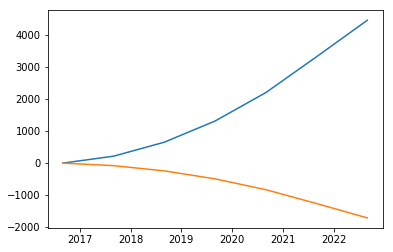

In [136]:
fig, ax = plt.subplots()
ax.plot(df['date'], df['waarde staatsleningen'] - df['schuld met rente 0.00'])
ax.plot(df['date'], df['waarde staatsleningen'] - df['schuld met rente {}'.format(leningrente*100)])
plt.show()